In [33]:
from pandas import Series
import pandas as pd
import numpy as np

from dataprep.eda import plot, plot_correlation, create_report, plot_missing
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [34]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')


In [35]:
train[:4]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0


In [36]:
test[:4]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N


In [37]:
sub[:4]

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501


### Проверим, пересекаются ли данные в тренировочном и тестовом датасетах


In [38]:
set(test.client_id) & set(set(train.client_id))

set()

##### (Не пересекаются)

### Объединяем таблицы с добавлением параметра-указателя принадлежности к тестовой выборке

In [39]:
train['test'] = 0
test['test'] =1
df = pd.concat([train,test],axis=0)

In [40]:
print(df[df['test']==0].shape)
print(df[df['test']==1].shape)


(73799, 20)
(36349, 20)


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 36348
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        110

Описания полей
client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту


####  Вывод: в тренировочной выборке   73799 записей, в тестовой 36349 записей. Имется небольшое количество пропусков в признаке education (0.43% суммарно), которые мы заполним. Данные в тренировочной и тестовой выборках не пересекаются 

In [42]:
df[:3]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,test
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,0


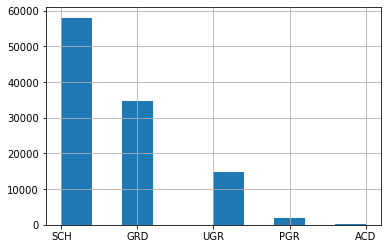

In [43]:
df['education'].hist()

In [44]:
edu_name = df['education'].value_counts().index.to_list() # Получаем список значений
edu_distr = df['education'].value_counts(normalize=True).values # Получаем список вероятностей
missing = df['education'].isnull() # Флаги с наличием пропусков
df.loc[missing, ['education']] = np.random.choice(
    edu_name, size=len(df[missing]), p=edu_distr) # Подставляем значения из списка имен в соответствии в вероятностью встречи имени

# 1.Анализ данных

<function matplotlib.pyplot.show(*args, **kw)>

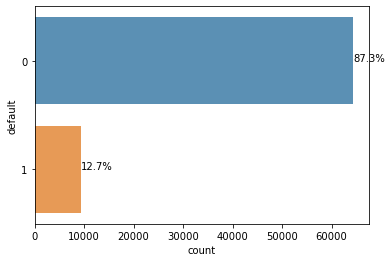

In [45]:
ax = sns.countplot(y='default', data= train, alpha=0.8)
total = train.shape[0]

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage,(x,y))
plt.show

client_id        |110148     |int64 
app_date         |120        |object 
education        |5          |object 
sex              |2          |object 
age              |52         |int64 
car              |2          |object 
car_type         |2          |object 
decline_app_cnt  |24         |int64 
good_work        |2          |int64 
score_bki        |102618     |float64 
bki_request_cnt  |40         |int64 
region_rating    |7          |int64 
home_address     |3          |int64 
work_address     |3          |int64 
income           |1207       |int64 
sna              |4          |int64 
first_time       |4          |int64 
foreign_passport |2          |object 
default          |2          |float64 
test             |2          |int64 


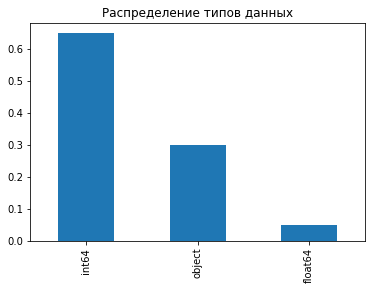

In [46]:
for i in df.columns:
    print('{0:<16} |{1:<10} |{2} '.format(i, df[i].nunique(), df[i].dtypes))
    train.dtypes.value_counts(normalize=True).plot(
        kind='bar', title='Распределение типов данных')

In [47]:
bin_ = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
num_ = ['age',  'income', 'score_bki']
cat_ = ['decline_app_cnt', 'bki_request_cnt', 'education',
        'work_address', 'home_address', 'sna', 'region_rating', 'first_time']

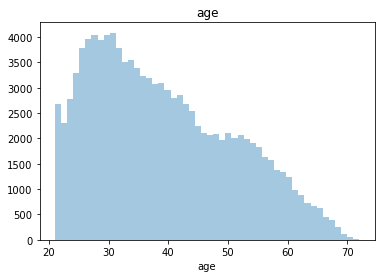

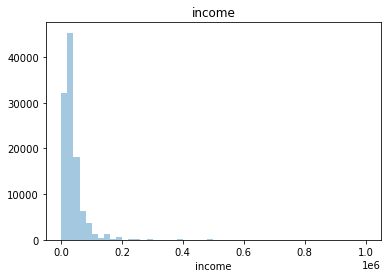

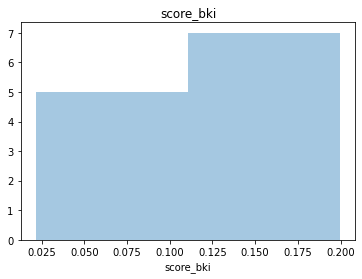

In [48]:
for i in num_:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

In [49]:
for_log_plot = df_num.copy()
for_log_plot['score_bki'] = for_log_plot['score_bki']+99999
for i in num_:
    plt.figure()
    sns.distplot(np.log(for_log_plot[i])[np.log(
        for_log_plot[i]) > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

NameError: name 'df_num' is not defined

In [ ]:
# pandas_profiling.ProfileReport(df.drop(['client_id','default','test'],axis=1))

In [ ]:
sns.heatmap(np.log(df[num_]).corr().abs(), vmin=0, vmax=1)
display(np.log(df[num_]).corr().abs())

In [ ]:
train.drop(bin_+cat_, axis=1).drop(['client_id', 'app_date', 'test'], axis=1)

In [ ]:
label_encoder = LabelEncoder()

for column in bin_:
    df_bin[column] = label_encoder.fit_transform(df_bin[bin_][column])

# убедимся в преобразовании
df_bin[bin_].head()

In [ ]:
df_cat['education'] = label_encoder.fit_transform(df_cat['education'])

In [ ]:
imp_cat = Series(mutual_info_classif(df_cat[df_cat['test'] == 0].drop(['test', 'default'], axis=1), df_cat['default'][df['test'] == 0],
                                     discrete_features=True), index=cat_)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [ ]:
imp_num = Series(f_classif(df_num[df_num['test'] == 0].drop(
    ['default', 'test'], axis=1), df_num['default'][df_num['test'] == 0])[0], index=num_)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [ ]:
df_num.drop(['test', 'default'], axis=1)

In [ ]:
df_num[df_num['test'] == 1].drop(['test', 'default'], axis=1)

In [ ]:
X_num_train = RobustScaler().fit_transform(
    df_num[df_num['test'] == 0].drop(['test', 'default'], axis=1).values)
X_cat_train = OneHotEncoder(sparse=False).fit_transform(
    df_cat[df_cat['test'] == 0].drop(['test', 'default'], axis=1).values)
X_bin_train = OneHotEncoder(sparse=False).fit_transform(
    df_bin[df_bin['test'] == 0].drop(['test', 'default'], axis=1).values)
X_num_test = RobustScaler().transform(
    df_num[df_num['test'] == 1].drop(['test', 'default'], axis=1).values)
X_cat_test = OneHotEncoder(sparse=False).fit(
    df_cat[df_cat['test'] == 1].drop(['test', 'default'], axis=1).values)
X_bin_test = OneHotEncoder(sparse=False).fit(
    df_bin[df_bin['test'] == 1].drop(['test', 'default'], axis=1).values)

In [ ]:
X_bin_train.shape

In [ ]:
X_train = np.hstack([X_num_train, X_cat_train, X_bin_train])
y_train = df['default'][df['test'] == 0].values
X_test = np.hstack([X_num_test, X_cat_test, X_bin_test])
y_sub = df['default'][df['test'] == 1].values

In [ ]:
X_num_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=50)

In [ ]:
model = LogisticRegression()
# model.fit(X_train,y_train)
# y_pred_proba = model.predict_proba(X_test)
# y_pred = model.predict(X_test)
model.fit(X, y)
y_pred_proba = model.predict_proba(X_sub)
y_pred = model.predict(X_sub)